<a href="https://colab.research.google.com/github/parkerhale/demo_project/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import


In [621]:
import os
from google.colab import drive
from argparse import Namespace
import numpy as np
import pandas as pd
import httpimport
import torch
import torch.optim as optim
from tqdm import tqdm_notebook, tqdm
import math
import statsmodels.formula.api as smf  
import statsmodels.api as sm
from numpy import genfromtxt
import csv
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from datetime import datetime
import torch.nn.functional as F
import random
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

#Data Preprocessing and EDA

In [622]:
url = "https://github.com/sundeepblue/movie_rating_prediction/raw/master/movie_metadata.csv"
data = pd.read_csv(url)
data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


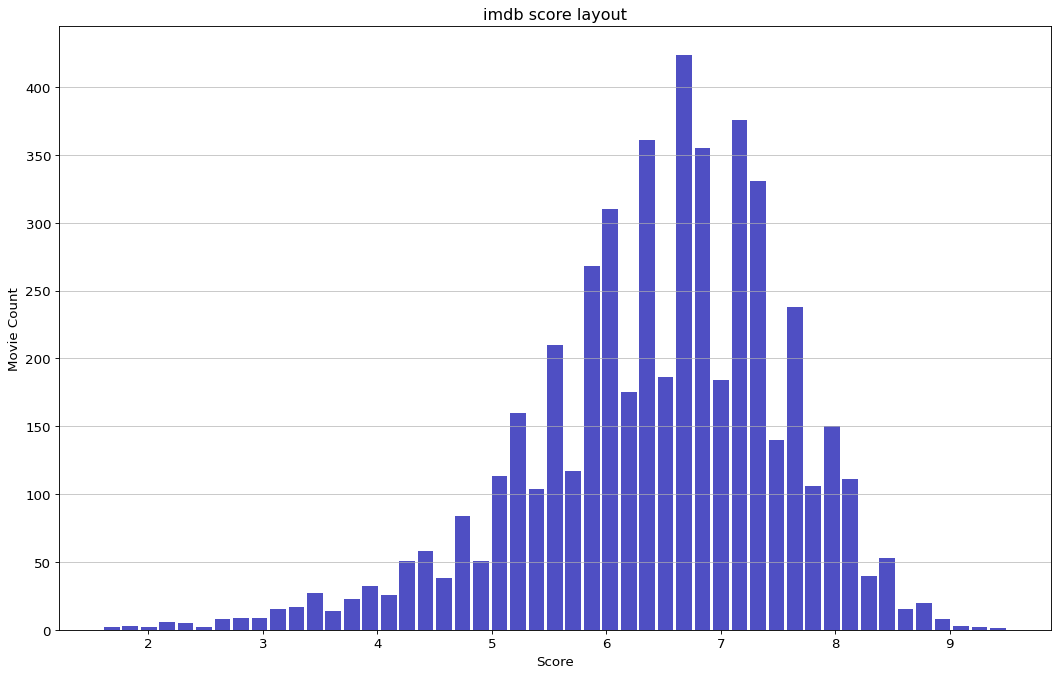

In [623]:
figure(figsize=(16, 10), dpi=80)
n, bins, patches = plt.hist(x=data['imdb_score'], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Score')
plt.ylabel('Movie Count')
plt.title('imdb score layout')
maxfreq = n.max()

We want to make a prediction for imdb scores. And as we know, the quality of movies is highly related to the person who direct them. Let's make a breif view of our producers.

In [624]:
director = data.groupby('director_name').size().sort_values(ascending=False).head(20)
director

director_name
Steven Spielberg     26
Woody Allen          22
Martin Scorsese      20
Clint Eastwood       20
Ridley Scott         17
Tim Burton           16
Spike Lee            16
Steven Soderbergh    16
Renny Harlin         15
Oliver Stone         14
Sam Raimi            13
Michael Bay          13
Barry Levinson       13
Robert Zemeckis      13
John Carpenter       13
Joel Schumacher      13
Ron Howard           13
Robert Rodriguez     13
Richard Donner       12
Shawn Levy           12
dtype: int64

Steven Spielberg is a reputated director, so as Woody Allen. I really appreciate their masterpieces during my childhood. I believe lots of audiences facinate their work as well. How about the average scores of their works?

In [625]:
name_list = director.index.tolist()
average = {}
for i in name_list:
  sum = data['imdb_score'][data['director_name'] == i].sum()  
  average[i] = sum/director[i]
sorted(average.items(), key=lambda x: -x[1])

[('Martin Scorsese', 7.659999999999999),
 ('Steven Spielberg', 7.480769230769232),
 ('Robert Zemeckis', 7.307692307692308),
 ('Clint Eastwood', 7.225),
 ('Ridley Scott', 7.070588235294117),
 ('Woody Allen', 7.00909090909091),
 ('Oliver Stone', 6.95),
 ('Tim Burton', 6.93125),
 ('Ron Howard', 6.93076923076923),
 ('John Carpenter', 6.915384615384615),
 ('Sam Raimi', 6.907692307692307),
 ('Richard Donner', 6.824999999999999),
 ('Steven Soderbergh', 6.70625),
 ('Michael Bay', 6.638461538461538),
 ('Barry Levinson', 6.576923076923076),
 ('Spike Lee', 6.56875),
 ('Joel Schumacher', 6.407692307692307),
 ('Shawn Levy', 6.033333333333334),
 ('Renny Harlin', 5.746666666666666),
 ('Robert Rodriguez', 5.6923076923076925)]

Christopher Nolan, my favorite sci-film director has the best overall imdb score. His moive is not just so good, or brilliant. It's beyond that. I have seen Inception for multiple times. Maybe I should do one more time.
<br>Ok, so we should agree that talented directors and casts will make a moive more entertaining and quality, which always result in a better rating. And we should consider that in our model.

In [626]:
director_score = pd.DataFrame(average.items(),columns=['Director','Score'])
director_score['Movies'] = director.to_list()
director_score

,Director,Score,Movies
0,Steven Spielberg,7.480769,26
1,Woody Allen,7.009091,22
2,Martin Scorsese,7.660000,20
3,Clint Eastwood,7.225000,20
4,Ridley Scott,7.070588,17
5,Tim Burton,6.931250,16
6,Spike Lee,6.568750,16
7,Steven Soderbergh,6.706250,16
8,Renny Harlin,5.746667,15
9,Oliver Stone,6.950000,14


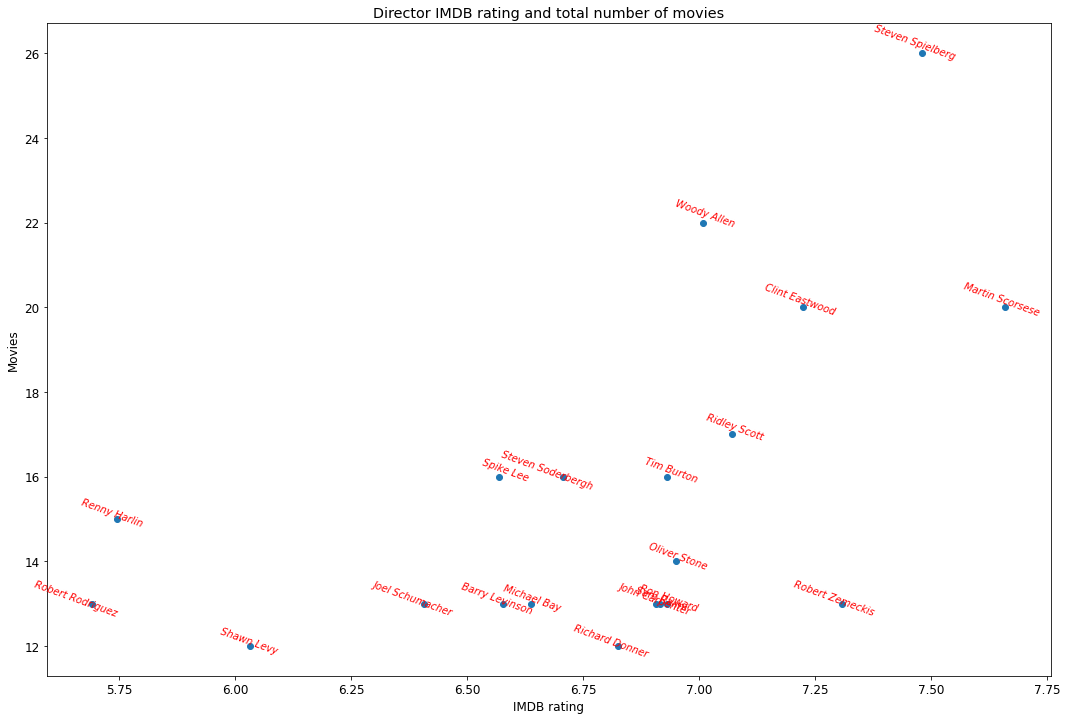

In [627]:
plt.rcParams['axes.unicode_minus']=False 
director=director_score['Director'] 
score=director_score['Score'] 
movies=director_score['Movies'] 

fig=plt.figure(figsize=(18,12))
ax=plt.subplot(1,1,1) 
ax.scatter(score,movies)    
ax.set_title("Director IMDB rating and total number of movies")
ax.set_xlabel("IMDB rating")
ax.set_ylabel("Movies")
for i in range(len(movies)):
    ax.text(score[i]*1.01, movies[i]*1.01, director[i], 
            fontsize=10, color = "r", style = "italic", weight = "light",
            verticalalignment='center', horizontalalignment='right',rotation=-20) 
plt.show()

As we can see, directors with good reputation also have produced lots of movies. Maybe audiences love those famous figures and lead to celebrity effect. 

In [628]:
director_score = sorted(average.items(), key=lambda x: -x[1])
type(director_score)

list

In [629]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

This dataset contains lots of information, including 9 characteristic variables, 15 numeric variables and 2 categorical variables. Before we processing feature engineering, I want to check data integrity so that missing values and outliers won't affect our prediction result.
The first step is to find out how many missing values we have here.

In [630]:
data.isna().sum()

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

That's a lot missing here. It is unpropriate if we processing the raw data without cleaning them out. 
<br>I would assume that those directors and actors who do not have "facebook likes" is because they do not have a official facebook account or is not avaliable currently. I would fill them as 0 to make it works. 

In [631]:
data['director_facebook_likes'] = data['director_facebook_likes'].fillna(0)
data['actor_1_facebook_likes'] = data['actor_1_facebook_likes'].fillna(0)
data['actor_2_facebook_likes'] = data['actor_2_facebook_likes'].fillna(0)
data['actor_3_facebook_likes'] = data['actor_3_facebook_likes'].fillna(0)

Face number in movies' poster should not affect review scores, as well as their imdb links, the number of reviews and aspect ratio.
<br>We have to admit that movie title might have positive or negative influence here. For instance, rating of movies in franchise series are affected by their precessors. Audiences always expect more on great movies' successors. On another hand, moives which named after a famous charactor, like spider-man or Donald Duck, will give their audiences a special impression.
<br>Still, I will delete these columns because their influence in this dataset is minimal and this will save us some time.

In [634]:
data_wo_useless_attributes = data.drop(columns=['color','movie_imdb_link','num_user_for_reviews','aspect_ratio','movie_title','plot_keywords','language','country'])

In [635]:
data_wo_useless_attributes = data_wo_useless_attributes.drop(columns=['facenumber_in_poster'])

Drop the na rows for numeric varibles. It is not approriate if we just fill them with means or median here. As we have enough samples here and na rows of numeric varibles are no more than 400 rows, I would say it is safer to focus on rows without missing values.

In [636]:
data_numeric_cleaned = data_wo_useless_attributes.dropna(subset=['num_critic_for_reviews','duration','director_name','title_year','gross','budget'])

In [637]:
data_categoric_cleaned = data_numeric_cleaned.dropna(subset=['director_name','actor_1_name','actor_2_name','actor_3_name','content_rating'])

In [638]:
data_categoric_cleaned.isna().sum()

director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
genres                       0
actor_1_name                 0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
movie_facebook_likes         0
dtype: int64

Index needs to be resets here to make sure following step will work well.

In [639]:
data_categoric_cleaned = data_categoric_cleaned.reset_index(drop=True)

In [640]:
data_categoric_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3833 entries, 0 to 3832
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   director_name              3833 non-null   object 
 1   num_critic_for_reviews     3833 non-null   float64
 2   duration                   3833 non-null   float64
 3   director_facebook_likes    3833 non-null   float64
 4   actor_3_facebook_likes     3833 non-null   float64
 5   actor_2_name               3833 non-null   object 
 6   actor_1_facebook_likes     3833 non-null   float64
 7   gross                      3833 non-null   float64
 8   genres                     3833 non-null   object 
 9   actor_1_name               3833 non-null   object 
 10  num_voted_users            3833 non-null   int64  
 11  cast_total_facebook_likes  3833 non-null   int64  
 12  actor_3_name               3833 non-null   object 
 13  content_rating             3833 non-null   objec

# Characteristic Variables and categorical variables

Genres is a little difficult to deal with. It has been put into one column and separate by "|". I will divide them into several columns using one hot coding. This is the only variable I want to use one hot coding since the labels is not so many.

In [641]:
data_categoric_cleaned['genres'].describe()

count                     3833
unique                     751
top       Comedy|Drama|Romance
freq                       150
Name: genres, dtype: object

In [642]:
genres = []
for i in range(len(data_categoric_cleaned)):
  temp = data_categoric_cleaned['genres'][i].split('|')
  for n in range(len(temp)):
    if temp[n] not in genres:
      genres.append(temp[n])

I create a list to store all genres values.

In [643]:
genres

['Action',
 'Adventure',
 'Fantasy',
 'Sci-Fi',
 'Thriller',
 'Romance',
 'Animation',
 'Comedy',
 'Family',
 'Musical',
 'Mystery',
 'Western',
 'Drama',
 'History',
 'Sport',
 'Crime',
 'Horror',
 'War',
 'Biography',
 'Music',
 'Documentary',
 'Film-Noir']

Create new empty columns for genres.

In [644]:
for i in genres:
  temp = [0]*len(data_categoric_cleaned)
  col_name = i
  data_categoric_cleaned[col_name] = temp

One-hot coding and we have genres attributes separated.

In [645]:
for i in range(len(data_categoric_cleaned)):
  temp = data_categoric_cleaned['genres'][i].split('|')
  for n in range(len(temp)):
    data_categoric_cleaned[temp[n]][i] = 1

In [646]:
data_categoric_cleaned[genres]

,Action,Adventure,Fantasy,Sci-Fi,Thriller,Romance,Animation,Comedy,Family,Musical,Mystery,Western,Drama,History,Sport,Crime,Horror,War,Biography,Music,Documentary,Film-Noir
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3828,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3829,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3830,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
3831,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0


Drop the original genres column

In [647]:
data_categoric_cleaned = data_categoric_cleaned.drop(columns=['genres'])
data_ready = data_categoric_cleaned

#One hot encoding for content rating

In [648]:
content_rating = pd.get_dummies(data_ready.content_rating, prefix='content_rating')
content_rating

,content_rating_Approved,content_rating_G,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_Unrated,content_rating_X
0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3828,0,0,0,0,0,0,0,1,0,0,0,0
3829,0,0,0,0,0,1,0,0,0,0,0,0
3830,0,0,0,0,0,0,0,0,0,1,0,0
3831,0,0,0,0,0,1,0,0,0,0,0,0


In [649]:
data_ready= data_ready.drop('content_rating',axis = 1)
data_ready = data_ready.join(content_rating)
data_ready

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,actor_1_name,num_voted_users,cast_total_facebook_likes,actor_3_name,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,Action,Adventure,Fantasy,Sci-Fi,Thriller,Romance,Animation,Comedy,Family,Musical,Mystery,Western,Drama,History,Sport,Crime,Horror,War,Biography,Music,Documentary,Film-Noir,content_rating_Approved,content_rating_G,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_Unrated,content_rating_X
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,CCH Pounder,886204,4834,Wes Studi,237000000.0,2009.0,936.0,7.9,33000,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Johnny Depp,471220,48350,Jack Davenport,300000000.0,2007.0,5000.0,7.1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Christoph Waltz,275868,11700,Stephanie Sigman,245000000.0,2015.0,393.0,6.8,85000,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Tom Hardy,1144337,106759,Joseph Gordon-Levitt,250000000.0,2012.0,23000.0,8.5,164000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Daryl Sabara,212204,1873,Polly Walker,263700000.0,2012.0,632.0,6.6,24000,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3828,Shane Carruth,143.0,77.0,291.0,8.0,David Sullivan,291.0,424760.0,Shane Carruth,72639,368,Casey Gooden,7000.0,2004.0,45.0,7.0,19000,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3829,Neill Dela Llana,35.0,80.0,0.0,0.0,Edgar Tancangco,0.0,70071.0,Ian Gamazon,589,0,Quynn Ton,7000.0,2005.0,0.0,6.3,74,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3830,Robert Rodriguez,56.0,81.0,0.0,6.0,Peter Marquardt,121.0,2040920.0,Carlos Gallardo,52055,147,Consuelo Gómez,7000.0,1992.0,20.0,6.9,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3831,Edward Burns,14.0,95.0,0.0,133.0,Caitlin FitzGerald,296.0,4584.0,Kerry Bishé,1338,690,Daniella Pineda,9000.0,2011.0,205.0,6.4,413,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#Directors and Actors

As I mentioned before, directors and actors have hugh influence on movies' quality. We surely don't want to drop these variables. But we have thounds of labels and one-hot coding won't going to make it. 
<br>As a result, I will replace their name by average imdb score of their works. And this number would represent their influence on movies' quality. <br>However, it happens when an actor only starred in one movie and it has a pretty high rating, while he is not acutally famous and make contribute to that fancy score. Thus, I will only consider the popular ones, that is, Top 50 for directors and Top 150 for actors. Other people would only get a overall average imdb score.

In [650]:
director = data_ready.groupby('director_name').size().sort_values(ascending=False).head(50)
name_list = director.index.tolist()
average = {}
for i in name_list:
  sum = data_ready['imdb_score'][data_ready['director_name'] == i].sum()  
  average[i] = sum/director[i]
imdb_average = data_ready['imdb_score'].mean()
score_column = [imdb_average]*len(data_ready)
data_ready['director_score'] = score_column
for i in range(len(data_ready)):
  if data_ready['director_name'][i] in name_list:
    data_ready['director_score'][i] = average[data_ready['director_name'][i]]

In [651]:
df1 = data_ready[['actor_1_name','imdb_score']]
df2 = data_ready[['actor_2_name','imdb_score']]
df3 = data_ready[['actor_3_name','imdb_score']]
df1.columns = ['name','imdb_score']
df2.columns = ['name','imdb_score']
df3.columns = ['name','imdb_score']

actor_concat = pd.concat([df1,df2,df3],axis = 0)
actor = actor_concat.groupby('name').size().sort_values(ascending=False).head(150)
actor

name
Robert De Niro          47
Morgan Freeman          44
Johnny Depp             39
Bruce Willis            39
Matt Damon              35
                        ..
David Oyelowo           11
Kristin Scott Thomas    11
Tom Hardy               11
Nathan Lane             11
Romany Malco            10
Length: 150, dtype: int64

In [652]:
name_list = actor.index.tolist()
average = {}
for i in name_list:
  sum = actor_concat['imdb_score'][actor_concat['name'] == i].sum()  
  average[i] = sum/actor[i]
imdb_average = data_ready['imdb_score'].mean()
score_column = [imdb_average]*len(data_ready)
data_ready['actor_1_score'] = score_column
data_ready['actor_2_score'] = score_column
data_ready['actor_3_score'] = score_column
for i in range(len(data_ready)):
  if data_ready['actor_1_name'][i] in name_list:
    data_ready['actor_1_score'][i] = average[data_ready['actor_1_name'][i]]
for i in range(len(data_ready)):
  if data_ready['actor_2_name'][i] in name_list:
    data_ready['actor_2_score'][i] = average[data_ready['actor_2_name'][i]]
for i in range(len(data_ready)):
  if data_ready['actor_3_name'][i] in name_list:
    data_ready['actor_3_score'][i] = average[data_ready['actor_3_name'][i]]
data_finished = data_ready.drop(columns=['director_name','actor_1_name','actor_2_name','actor_3_name'])

In [653]:
data_finished

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,Action,Adventure,Fantasy,Sci-Fi,Thriller,Romance,Animation,Comedy,Family,Musical,Mystery,Western,Drama,History,Sport,Crime,Horror,War,Biography,Music,Documentary,Film-Noir,content_rating_Approved,content_rating_G,content_rating_GP,content_rating_M,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_Passed,content_rating_R,content_rating_Unrated,content_rating_X,director_score,actor_1_score,actor_2_score,actor_3_score
0,723.0,178.0,0.0,855.0,1000.0,760505847.0,886204,4834,237000000.0,2009.0,936.0,7.9,33000,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.459144,6.459144,6.459144,6.459144
1,302.0,169.0,563.0,1000.0,40000.0,309404152.0,471220,48350,300000000.0,2007.0,5000.0,7.1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.459144,6.794872,6.459144,6.459144
2,602.0,148.0,0.0,161.0,11000.0,200074175.0,275868,11700,245000000.0,2015.0,393.0,6.8,85000,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.459144,6.459144,6.459144,6.459144
3,813.0,164.0,22000.0,23000.0,27000.0,448130642.0,1144337,106759,250000000.0,2012.0,23000.0,8.5,164000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.459144,7.500000,7.266667,7.055556
4,462.0,132.0,475.0,530.0,640.0,73058679.0,212204,1873,263700000.0,2012.0,632.0,6.6,24000,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.459144,6.459144,6.459144,6.459144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3828,143.0,77.0,291.0,8.0,291.0,424760.0,72639,368,7000.0,2004.0,45.0,7.0,19000,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.459144,6.459144,6.459144,6.459144
3829,35.0,80.0,0.0,0.0,0.0,70071.0,589,0,7000.0,2005.0,0.0,6.3,74,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6.459144,6.459144,6.459144,6.459144
3830,56.0,81.0,0.0,6.0,121.0,2040920.0,52055,147,7000.0,1992.0,20.0,6.9,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5.692308,6.459144,6.459144,6.459144
3831,14.0,95.0,0.0,133.0,296.0,4584.0,1338,690,9000.0,2011.0,205.0,6.4,413,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,6.459144,6.459144,6.459144,6.459144


# Dataset Split

In [654]:
df = data_finished.sample(n = len(data_finished), random_state = 1)
df_data = df.reset_index(drop = True)
df_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


In [664]:
df_train = df_data.drop(df_test.index)

In [666]:
col_to_use = [c for c in list(df_train.columns) if c != 'imdb_score']
print('Number of attributes:', len(col_to_use))

Number of attributes: 50


In [669]:
X_train = df_train[col_to_use].values
X_test = df_test[col_to_use].values
y_train = df_train['imdb_score'].values
y_test = df_test['imdb_score'].values
print('Training shapes:',X_train.shape, y_train.shape)
print('Testing shapes:',X_test.shape, y_test.shape)

Training shapes: (2683, 50) (2683,)
Testing shapes: (1150, 50) (1150,)


#Simple Multiple Linear Regression



In this section, I build a very simple linear regression model as baseline.

In [671]:
y_train_a = y_train[:, np.newaxis]
model = LinearRegression() # 构建线性模型
model.fit(X_train, y_train_a) # 自变量在前，因变量在后
predicts = model.predict(X_train) # 预测值
R2 = model.score(X_train, y_train_a) # 拟合程度 R2
print('R2 = %.3f' % R2) # 输出 R2
coef = model.coef_ # 斜率
intercept = model.intercept_ # 截距

R2 = 0.510


Print out the coefficients

In [672]:
print(model.coef_, model.intercept_) 

[[ 2.70883066e-03  3.55507208e-03 -5.59449149e-06  2.06409374e-05
   3.38771744e-05 -7.55508897e-10  2.40908781e-06 -3.25872946e-05
   2.80442009e-11 -2.74853818e-02  2.70217136e-05 -5.56086774e-07
  -2.15239587e-01 -3.61999366e-02 -1.04619311e-01 -1.26337145e-01
  -1.47651091e-01 -4.67495234e-02  8.27405488e-01 -1.25923585e-01
  -1.28848276e-01  4.21869143e-02  2.11041090e-02 -1.15995904e-01
   4.46069174e-01  8.36354779e-02  1.29653834e-01  6.68189254e-02
  -4.09519883e-01  1.00665257e-01  1.51313349e-01  1.20464296e-02
   9.68588259e-01 -7.48238020e-01  9.31309005e-04 -1.47046577e-01
  -5.97934228e-02  3.50160474e-02 -1.88684141e-01  5.03294612e-01
  -3.46058594e-02 -1.44973975e-01 -7.33025727e-01  4.76272706e-02
   3.25879720e-01  3.95380744e-01  1.43622546e-01  1.79400114e-01
   2.87293649e-01  1.06431000e-01]] [55.82515277]


In [673]:
LR_result = model.predict(X_test)

#Ridge and LASSO Regression

In order to prevent over-fitting of the model, we often need to add regularization items when building a linear model, generally there are L1 regularization and L2 regularization. Ridge regression(L2) and Lasso(L1) can prevet overfitting. 
<br>Ridge regression reduces the regression coefficients without abandoning any feature, making the model relatively stable, but compared with Lasso regression, this will leave a lot of model features and poor model interpretation.
<br>The regularization term of ridge regression has a constant coefficient alpha to adjust the weight of the mean square error term and the regularization term of the loss function. Larger alpha means more penalty. I set two initial alpha to find their difference.

In [674]:
lr = LinearRegression()
lr.fit(X_train, y_train)

rr = Ridge(alpha=0.01) 
rr.fit(X_train, y_train)

rr100 = Ridge(alpha=100) 
rr100.fit(X_train, y_train)

train_score=lr.score(X_train, y_train)
test_score=lr.score(X_valid, y_valid)

Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_valid, y_valid)

Ridge_train_score100 = rr100.score(X_train,y_train)
Ridge_test_score100 = rr100.score(X_valid, y_valid)

print ("linear regression train score:", train_score)
print ("linear regression test score:", test_score)
print ("ridge regression train score low alpha:", Ridge_train_score)
print ("ridge regression test score low alpha:", Ridge_test_score)
print ("ridge regression train score high alpha:", Ridge_train_score100)
print ("ridge regression test score high alpha:", Ridge_test_score100)

linear regression train score: 0.5098707388489385
linear regression test score: 0.4793769609946402
ridge regression train score low alpha: 0.5098707081208159
ridge regression test score low alpha: 0.479384777543556
ridge regression train score high alpha: 0.49196034919115267
ridge regression test score high alpha: 0.4653872606092868


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


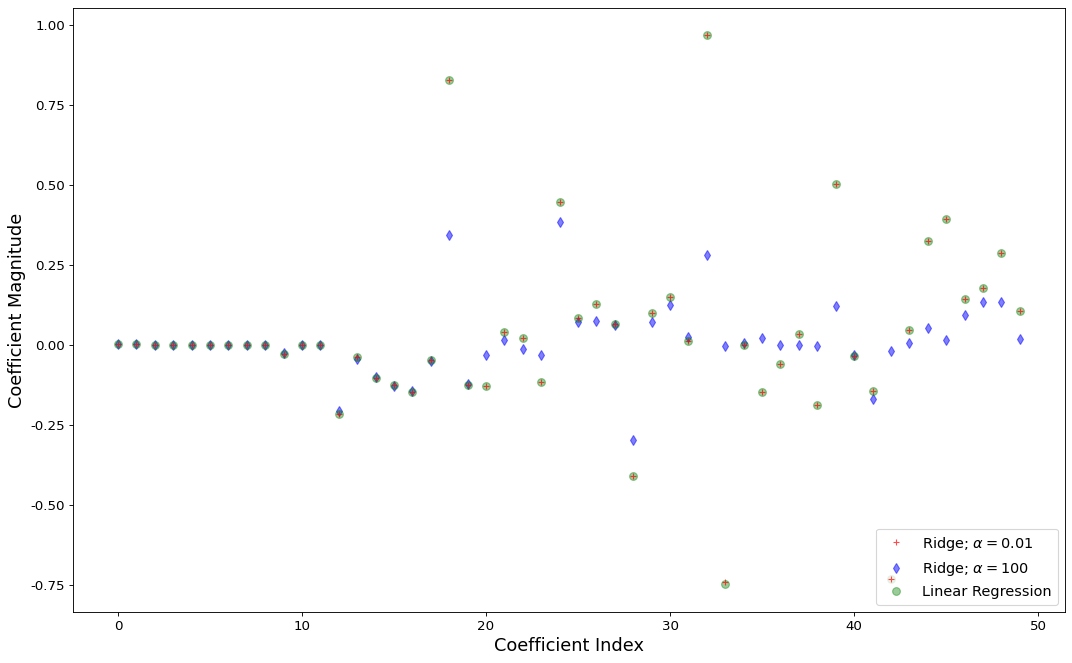

In [675]:
figure(figsize=(16, 10), dpi=80)
plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='+',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7)
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') 
plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

As we can see, when alpha = 0.01, the coefficient is pretty close to linear regression. Lots of coefficient remain the same. We are still going to have much overfitting. 
<br>To save some time, I evade creating a loop to find the best alpha, but rather using sklearn to calculate it at once.

In [676]:
from sklearn.linear_model import RidgeCV
ridgecv = RidgeCV(alphas=[0.01, 0.1, 0.5, 1, 5, 7, 10, 30,100, 200])
ridgecv.fit(X_train, y_train)
print("Best alpha should be:" + str(ridgecv.alpha_)) 

Best alpha should be:5.0


Ok, alpha = 5. Fit the model again and we will make comparision later.

In [677]:
rr5 = Ridge(alpha=5) 
rr5.fit(X_train, y_train)
rr_result = rr5.predict(X_test)

Without abandoning any feature, ridge regression reduces the regression coefficients, making the model relatively stable. But compared with Lasso regression, this will leave a lot of model features and poor model interpretation. 

training score: 0.3354963706780224
test score:  0.2790770637234491
number of features used:  12
training score for alpha=0.01: 0.4852405649033092
test score for alpha =0.01:  0.4572169458961612
number of features used: for alpha =0.01: 27
training score for alpha=0.0001: 0.5098119359755454
test score for alpha =0.0001:  0.4797847516161179
number of features used: for alpha =0.0001: 47
LR training score: 0.5098707388489385
LR test score:  0.4793769609946402


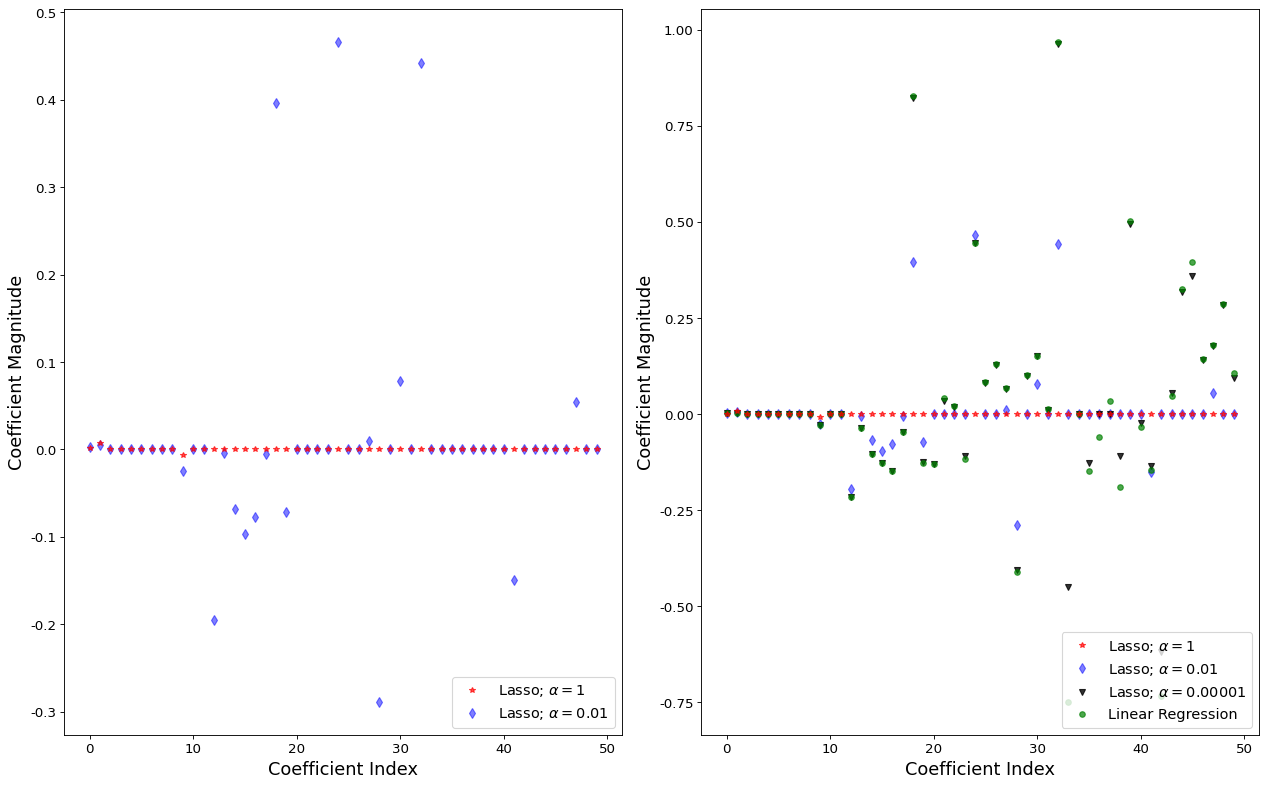

In [678]:
lasso = Lasso() # 默认alpha =1 
lasso.fit(X_train,y_train)

train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_valid,y_valid)

coeff_used = np.sum(lasso.coef_!=0)
print("training score:", train_score )
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)

lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)

train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_valid,y_valid)

coeff_used001 = np.sum(lasso001.coef_!=0)
print ("training score for alpha=0.01:", train_score001 )
print ("test score for alpha =0.01: ", test_score001)
print ("number of features used: for alpha =0.01:", coeff_used001)

lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train,y_train)

train_score00001=lasso00001.score(X_train,y_train)
test_score00001=lasso00001.score(X_valid,y_valid)

coeff_used00001 = np.sum(lasso00001.coef_!=0)
print ("training score for alpha=0.0001:", train_score00001 )
print( "test score for alpha =0.0001: ", test_score00001)
print ("number of features used: for alpha =0.0001:", coeff_used00001)

lr = LinearRegression()
lr.fit(X_train,y_train)
lr_train_score=lr.score(X_train,y_train)
lr_test_score=lr.score(X_valid,y_valid)
print ("LR training score:", lr_train_score )
print ("LR test score: ", lr_test_score)
figure(figsize=(16, 10), dpi=80)

plt.subplot(1,2,1)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.subplot(1,2,2)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency
plt.plot(lasso00001.coef_,alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',label=r'Lasso; $\alpha = 0.00001$') # alpha here is for transparency
plt.plot(lr.coef_,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',label='Linear Regression',zorder=2)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.tight_layout()
plt.show()

When we look at the picture on the left, we can see that for alpha = 1,most of the coefficients are zero or close to zero. Lasso kills too many features. And with alpha = 0.01, this model has more features.
When we set alpha = 0.0001, 47 non-zero feature attributes remain in the model and the training and test scores are the same as the basic linear regression. Based on this result, alpha = 0.01 could be a little better.

In [679]:
lasso_result = lasso001.predict(X_test)

#Model Comparation

In [680]:
result_table = pd.DataFrame(y_test)
result_table.columns = ['IMDB_score']
result_table['Linear'] = LR_result
result_table['Ridge'] = rr_result
result_table['Lasso'] = lasso_result
result_table.sort_values(by=['IMDB_score'])
new_table = result_table.reset_index(drop=True)
new_table

,IMDB_score,Linear,Ridge,Lasso
0,4.3,5.688365,5.695836,5.806589
1,4.6,6.126685,6.118443,6.167607
2,6.5,5.987510,5.995089,6.169073
3,6.6,6.307683,6.302308,6.168252
4,7.3,6.662066,6.663338,6.661530
...,...,...,...,...
1145,7.5,5.984478,6.002163,6.017775
1146,6.8,6.471635,6.487194,6.620229
1147,6.7,6.435611,6.386730,6.210141
1148,8.0,7.287553,7.291819,7.550669


In [681]:
IMDB_score = new_table['IMDB_score']
linear = new_table['Linear']
ridge = new_table['Ridge']
lasso = new_table['Lasso']
index = range(len(new_table))

Text(0, 0.5, 'Score')

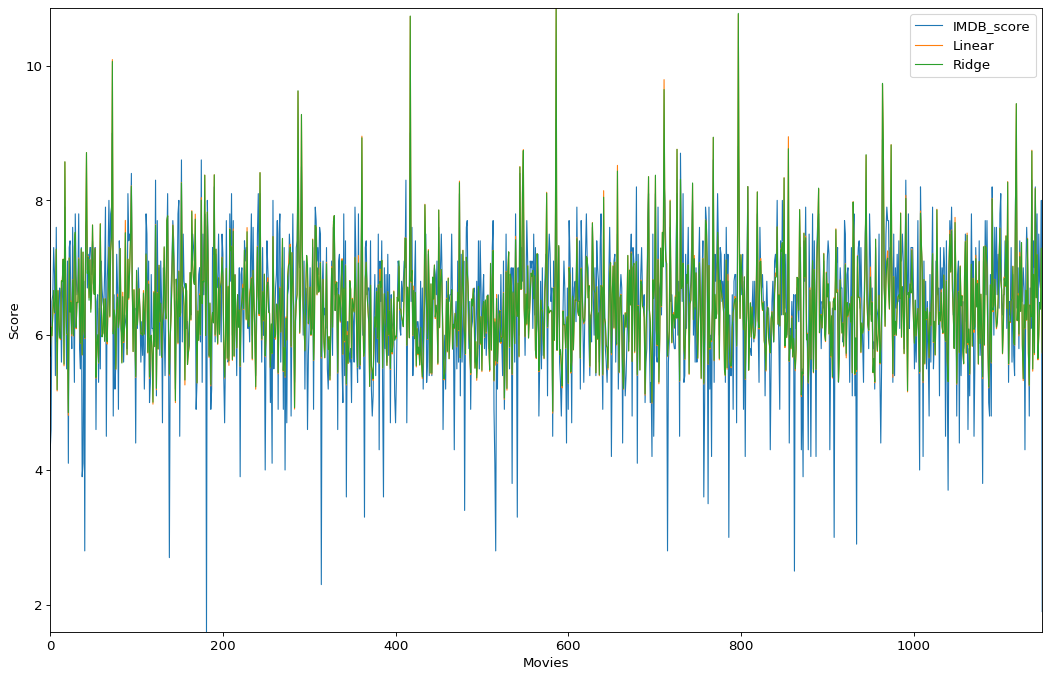

In [682]:
figure(figsize=(16, 10), dpi=80)
plt.plot(index,  IMDB_score, mec='r', mfc='w',label='IMDB_score',linewidth=1)

plt.plot(index, linear, mec='r', mfc='w',label='Linear',linewidth=1)
plt.plot(index, ridge, ms=10,label='Ridge',linewidth=1)
plt.legend()  
 
plt.margins(0)
plt.subplots_adjust(bottom=0.10)
plt.xlabel('Movies') 
plt.ylabel("Score")


In [683]:
print(f"Linear Regression MSE：{mean_squared_error(LR_result, y_test)}")
print(f"Linear Regression RMSE：{np.sqrt(mean_squared_error(LR_result, y_test))}")
print(f"Linear Regression R^2：{r2_score(y_test, LR_result)}")

Linear Regression MSE：0.584968462720589
Linear Regression RMSE：0.7648323101965483
Linear Regression R^2：0.46195133755505724


In [684]:
print(f"Ridge Regression MSE：{mean_squared_error(rr_result, y_test)}")
print(f"Ridge Regression RMSE：{np.sqrt(mean_squared_error(rr_result, y_test))}")
print(f"Ridge Regression R^2：{r2_score(y_test, rr_result)}")

Ridge Regression MSE：0.5835446818982589
Ridge Regression RMSE：0.7639009634096942
Ridge Regression R^2：0.4632609181835694


In [685]:
print(f"Lasso Regression MSE：{mean_squared_error(lasso_result, y_test)}")
print(f"Lasso Regression RMSE：{np.sqrt(mean_squared_error(lasso_result, y_test))}")
print(f"Lasso Regression R^2：{r2_score(y_test, lasso_result)}")

Lasso Regression MSE：0.6004378791253496
Lasso Regression RMSE：0.7748792674509686
Lasso Regression R^2：0.4477227092856373
